# Deep Learning HW3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Class distribution in training data: Counter({'ship': 1010, 'cars': 1000, 'airplanes': 1000})
Found 3010 files belonging to 3 classes.
Found 582 files belonging to 3 classes.
Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 312ms/step - accuracy: 0.3598 - loss: 3.2381 - val_accuracy: 0.3436 - val_loss: 2.9801
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 484ms/step - accuracy: 0.3953 - loss: 2.9107 - val_accuracy: 0.3436 - val_loss: 2.7452
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.4141 - loss: 2.6568 - val_accuracy: 0.3247 - val_loss: 2.5519
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.4535 - loss: 2.4220 - val_accuracy: 0.3436 - val_loss: 2.3707
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.4406 - loss: 2.2635 - val_accuracy: 

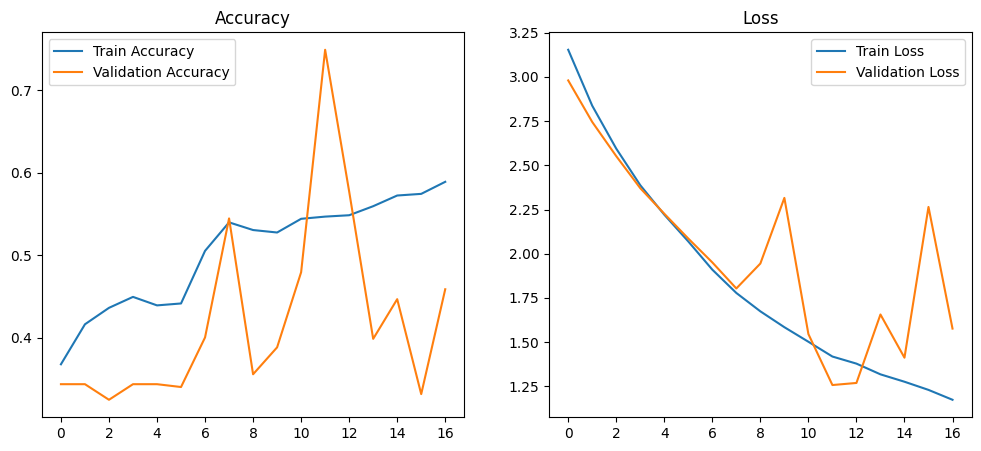

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7443 - loss: 1.2683
Test Accuracy: 74.91%
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 689ms/step


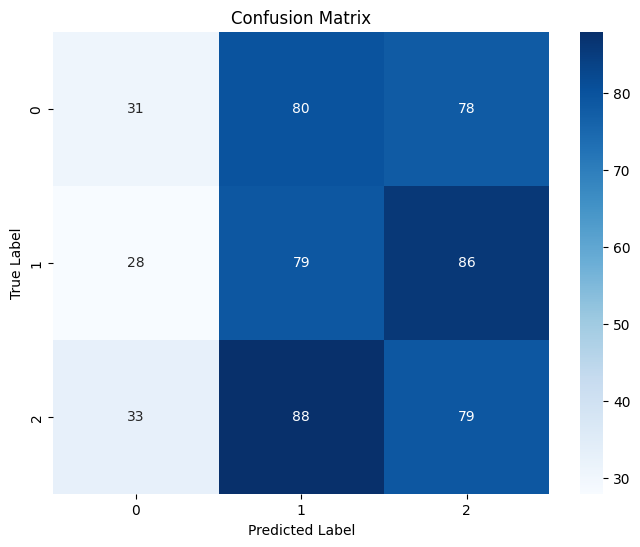

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.16      0.22       189
           1       0.32      0.41      0.36       193
           2       0.33      0.40      0.36       200

    accuracy                           0.32       582
   macro avg       0.33      0.32      0.31       582
weighted avg       0.33      0.32      0.31       582



In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
import collections

# Mount Google Drive
drive.mount('/content/drive')

# Enable GPU strategy
strategy = tf.distribute.MirroredStrategy()
print("✅ Using GPU:", tf.config.list_physical_devices('GPU'))

# Enable XLA for faster computation
tf.config.optimizer.set_jit(True)

# Define paths (Google Drive dataset path)
base_dir = "/content/drive/MyDrive/Deep_Learning/Dataset"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Define parameters
width, height = 128, 128  # Reduced image size for faster processing
batch_size = 64  # Increased batch size for more stable updates
num_classes = len(os.listdir(train_dir))  # Dynamically determine number of classes

# Check class distribution in dataset
class_counts = collections.Counter()
for class_name in os.listdir(train_dir):
    num_files = len(os.listdir(os.path.join(train_dir, class_name)))
    class_counts[class_name] = num_files
print("Class distribution in training data:", class_counts)

with strategy.scope():
    # Load dataset inside strategy
    def preprocess_image(image, label):
        image = tf.image.resize(image, [width, height]) / 255.0
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.8)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.8)
        image = tf.image.random_hue(image, max_delta=0.08)

        # AugMix Strategy (Ensure consistency in dimensions)
        mix1 = tf.image.rot90(image)
        mix2 = tf.image.random_crop(image, [tf.shape(image)[0], width - 10, height - 10, 3])

        mix2 = tf.image.resize(mix2, [width, height])  # Resize cropped image back to original shape

        # Combine augmentations
        image = 0.5 * image + 0.25 * mix1 + 0.25 * mix2

        return image, label

    train_dataset = image_dataset_from_directory(
        train_dir,
        image_size=(width, height),
        batch_size=batch_size,
        label_mode='categorical'  # Ensures labels are one-hot encoded
    ).map(preprocess_image).prefetch(tf.data.AUTOTUNE)

    val_dataset = image_dataset_from_directory(
        test_dir,
        image_size=(width, height),
        batch_size=batch_size,
        label_mode='categorical'
    ).map(lambda x, y: (x / 255.0, y)).prefetch(tf.data.AUTOTUNE)

    # Learning Rate Scheduler
    initial_learning_rate = 0.0002  # Reduced LR for more stable training
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=500,
        decay_rate=0.95,
        staircase=True
    )

    optimizer = Adam(learning_rate=lr_schedule)

    # Compute class weights
    labels = []
    for _, y in train_dataset.unbatch():
        labels.append(np.argmax(y.numpy()))
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Model Definition
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(width, height, 3))

    base_model.trainable = False  # Freeze all layers initially
    for layer in base_model.layers[-50:]:  # Unfreeze only the last 50 layers
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Use GAP instead of Flatten
        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),  # Added L2 Regularization
        Dropout(0.5),  # Dropout added
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    class_weight=class_weight_dict  # Apply class weights
)

# Plot Training Performance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

# Evaluate Model
test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrix & Classification Report
y_true_labels = np.concatenate([y.numpy() for _, y in val_dataset], axis=0)
y_true_labels = np.argmax(y_true_labels, axis=1)  # Convert one-hot to class labels
y_pred_probs = model.predict(val_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Compute Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred))